In [19]:
import torch
import torch.nn as nn

import pdb

from modules import *

"""
Direction Attractor Net

Inspired by 
Y. Nakagome, M. Togami, T. Ogawa and T. Kobayashi, "Deep Speech Extraction with Time-Varying Spatial Filtering Guided By Desired Direction Attractor," ICASSP 2020 - 2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Barcelona, Spain, 2020, pp. 671-675, doi: 10.1109/ICASSP40776.2020.9053629.

NOTE : Because there are too many untold components, major parts of this code are improvisations. 
"""
class DirectionAttractor(nn.Module) : 
    def __init__(self,
                 n_channel=4,
                 n_spectral = 4,
                 n_angle=2,
                 n_fft=512,
                 n_dim=1024,
                 n_hidden_layer=4,
                 n_latent = 257,
                 n_rnn_layer=2,
                 type_activation=None,
                 type_normalization=None,
                 type_activation_out=None,
                 dropout = 0.0,
                 out_cplx = False
                 ):
        super(DirectionAttractor, self).__init__()
        n_hfft = n_fft//2+1
        n_dim = 1024
        if out_cplx :
            n_dim_out = 2*n_channel*n_hfft
        else :
            n_dim_out = 1*n_channel*n_hfft

        self.F = n_hfft
        self.C = n_channel

        self.D = encoder(
                n_in = n_spectral*n_hfft,
                n_dim=n_dim,
                n_hidden_layer=n_hidden_layer,
                n_out = n_latent,
                type_activation=type_activation,
                type_normalization=type_normalization,
                dropout=dropout
        )  

        self.Z_s = encoder(
                n_in = n_angle,
                n_dim=n_dim,
                n_hidden_layer=n_hidden_layer,
                n_out= n_latent,
                type_activation=type_activation,
                type_normalization=type_normalization,
                dropout=dropout
        )

        self.Z_n = encoder(
                n_in = n_angle,
                n_dim=n_dim,
                n_hidden_layer=n_hidden_layer,
                n_out = n_latent,
                type_activation=type_activation,
                type_normalization=type_normalization,
                dropout=dropout
        )

        self.RNN_s = RNN(n_latent,n_latent,n_rnn_layer=n_rnn_layer)
        self.RNN_n = RNN(n_latent,n_latent,n_rnn_layer=n_rnn_layer)

        self.estimation_target_mask = estimator(n_latent,n_dim_out)
        self.estimation_target_activity= estimator(n_latent,1)
        self.estimation_noise_mask = estimator(n_latent,n_dim_out)
        self.estimation_noise_activity = estimator(n_latent,1)

        self.activation_1 = nn.Sigmoid()
        self.activation_2 = nn.Tanh()

    def forward(self,spectral_feature,angle):
        B = spectral_feature.shape[0]
        T = spectral_feature.shape[1]
        e = self.D(spectral_feature)

        a_s = self.Z_s(angle)
        a_n = self.Z_n(angle)

        """
        e : [B, T, F']
        a_s : [B,  F']
        a_n : [B,  F']
        """

        #print("e : {} | a_s {} | a_n {}".format(e.shape,a_s.shape,a_n.shape))
        return a_s,a_n
        
        
        e_s = e * a_s
        e_n = e * a_n

        e_s = self.RNN_s(e_s)
        e_n = self.RNN_n(e_n)
        
       

        #e_s = self.RNN_s(e)
        #e_n = self.RNN_n(e)

        #print("e_s {} | e_n {}".format(e_s.shape,e_n.shape))

        M_s = self.estimation_target_mask(e_s)
        v_s = self.estimation_target_activity(e_s)
        M_n = self.estimation_noise_mask(e_n)
        v_n = self.estimation_noise_activity(e_n)

        #print("M_s {} | V_s {} | M_n {} | V_n {}".format(M_s.shape, v_s.shape, M_n.shape,v_n.shape) )

        M_s = self.activation_2(M_s)
        v_s = self.activation_1(v_s)
        M_n = self.activation_2(M_n)
        v_n = self.activation_1(v_n)

        M_s = torch.reshape(M_s,(B,T,self.F,self.C))
        M_n = torch.reshape(M_n,(B,T,self.F,self.C))
        """
        M_s = torch.reshape(M_s,(B,T,self.F,self.C,2))
        M_n = torch.reshape(M_n,(B,T,self.F,self.C,2))
        M_s = M_s[...,0] + 1j*M_s[...,1]
        M_n = M_n[...,0] + 1j*M_n[...,1]
        """
        return M_s,v_s,M_n,v_n

class DirectionAttractorNet(nn.Module):
    def __init__(self,
                 n_channel=4,
                 n_fft=512,
                 dist=1,
                 method_out = "mask_mag",
                 type_activation=None,
                 type_normalization=None,
                 type_activation_out=None,
                 dropout = 0.0,
                 spectral_feature = ["x","SV"],
                 angle_feature = "theta"
                 ):
        super(DirectionAttractorNet, self).__init__()

        self.sr = 16000
        self.ss = 340.4

        self.n_channel = n_channel
        self.n_fft = n_fft
        self.n_hfft = n_fft//2+1
        self.window = torch.hann_window(self.n_fft)

        self.dist = dist

        channel_feature = 0
        if "X" in spectral_feature :
            channel_feature += n_channel*2
        if "SV" in spectral_feature :
            channel_feature += n_channel*2

        self.spectral_feature = spectral_feature
        
        if method_out == "mask_mag" :
            self.f_out = self.masking
            self.out_cplx = False
        elif method_out == "mask_cplx" : 
            self.f_out = self.masking
            self.out_cplx = True
        elif method_out == "MVDR" :
            self.f_out = self.MVDR
        else : 
            raise Exception("{} is not implemented".format(method_out))
        
        self.anlgle_feature = angle_feature
        if angle_feature == "theta" : 
            n_angle = 2
        elif angle_feature == "absSV" : 
            n_angle = self.n_hfft*n_channel
        elif angle_feature == "SV" : 
            n_angle = self.n_hfft*2*n_channel
        else :
            raise Exception("{} is unknown type of anlge feature".format(angle_feature))
        
        self.DAN = DirectionAttractor(
            n_channel=n_channel,
            n_fft=n_fft,
            type_activation=type_activation,
            type_normalization=type_normalization,
            type_activation_out=type_activation_out,
            dropout=dropout,
            n_spectral = channel_feature,
            n_angle = n_angle,
            out_cplx = self.out_cplx
            )
    
        
    def steering_vector(self,angle,mic_pos) :
        """
        angle : [B, 1]
        """
        # init
        B = angle.shape[0]
        loc_src = torch.zeros(B,3).to(mic_pos.device)

        loc_src[:,0] = self.dist*torch.cos((-angle)/180*torch.pi)*torch.sin(torch.tensor(90/180*torch.pi))
        loc_src[:,1] = self.dist*torch.sin((-angle)/180*torch.pi)*torch.sin(torch.tensor(90/180*torch.pi))
        loc_src[:,2] = self.dist*torch.cos(torch.tensor((90)/180*torch.pi))

        TDOA = torch.zeros(B,self.n_channel).to(mic_pos.device)
        for i in range(self.n_channel) : 
            TDOA[:,i] = torch.norm(mic_pos[:,i] - loc_src)
        TDOA = TDOA[:,:] - TDOA[:,0:1]

        const = -1j*2*torch.pi*self.sr/(self.n_fft*self.ss)
        SV  = torch.zeros(B,self.n_channel,self.n_hfft,dtype=torch.cfloat).to(mic_pos.device)
        for i in torch.arange(B) : 
            for j in range(self.n_hfft) : 
                SV[i,:,j] = torch.exp(j*TDOA[i]*const)
                SV[i,:,j] /= torch.norm(SV[i,:,j])

        return SV

    def anlge_pre(self,angle):
        sin_theta = torch.sin((-angle)/180*torch.pi)
        cos_theta = torch.cos((-angle)/180*torch.pi)
        return torch.stack((sin_theta,cos_theta),1)
    
    def cal_covariance(self,X,M_s,v_s,M_n,v_n) : 
        raise Exception("cal_covariance()::Not implemented yet")
        # X : [B, C, F, T]
        B,C,F,T = X.shape

        X_ = torch.permute(X,(0,2,3,1))
        X_ = torch.reshape(X_,(B*F*T,C,1))

        R = torch.bmm(X_,torch.permute(X_,(0,2,1)))
        # diagonal loading
        R += torch.eye(C)*1e-4

        R_inv = torch.inverse(R)

        W = v_s*M_s*X

        Y = W*X
        return Y
    """
    X = B,C,F,T
    h = B,C,F,T
    M_n = B,T,F,C
    v_n = B,T,1
    """
    def MVDR(self,X,h,M_s,v_s,M_n,v_n):
        B,C,F,T = X.shape

        v_n = torch.reshape(v_n,(B,T,1,1))
        G_n = M_n*v_n

        # B,T,F,C -> B,F,T,C
        G_n = torch.permute(G_n,(0,2,1,3))
        G_n = torch.reshape(G_n,(B*F*T,1,C))

        X = torch.permute(X,(0,2,3,1))
        X = torch.reshape(X,(B*F*T,1,C))

        GnX = 0.5*G_n*X + 0.5*X

        Rn = torch.transpose(GnX,1,2)*GnX

        h = torch.permute(h,(0,2,3,1))
        h = torch.reshape(h,(B*F*T,C,1))

        hT = torch.transpose(h,1,2)

        # invsese 
        Rn_inv = torch.inverse(Rn + torch.eye(C).to(Rn.device)*1e-4)

        numer = torch.bmm(Rn_inv,h)
        denom = torch.bmm(torch.bmm(hT,Rn_inv),h)

        w = numer/denom

        bY = torch.bmm(X,w)

        Y = torch.reshape(bY,(B,F,T))
        return Y

    """
    X : [B,C,F,T]
    """
    def masking(self,X,h,M_s,v_s,M_n,v_n):
        # TODO : complex mask

        B,T,F,C = M_s.shape
        v_s = torch.reshape(v_s,(B,T,1,1))
        v_n = torch.reshape(v_s,(B,T,1,1))

        # W : [B, T, F]
        #w = (M_s*v_s)/(M_n*v_n+1e-6)

        w = M_s*v_s - M_n*v_n
        #w = (M_s*v_s)

        w = w.permute(0,2,1,3)
        Y = w[:,:,:,0]*X[:,0,:,:]
        return Y

    """
    x : [B, C, L], mutli-channel time-domain signal
    y : [B, 1, L], estimated time-domain signal
    """
    def forward(self,x,angle,mic_pos):
        # reshape : [B, C, L] -> [B * C, L]
        B,C,L = x.shape
        x = torch.reshape(x,(B*C,L))
        X = torch.stft(x,n_fft = self.n_fft,window=self.window.to(x.device),return_complex=True)
        _, F,T = X.shape
        X = X.reshape(B,C,F,T)

        # reshape :
        a = self.steering_vector(angle,mic_pos)
        a = a.unsqueeze(-1).expand(-1, -1, -1, T)

        """
            Spectral Features
        """
        spec_feat = None
        if "X" in self.spectral_feature : 
            if spec_feat is None : 
                spec_feat = torch.cat([X.real,X.imag],dim=1)
            else : 
                spec_feat = torch.cat([spec_feat,X.real,X.imag],dim=1)

        if "SV" in self.spectral_feature : 
            if spec_feat is None : 
                spec_feat = torch.cat([a.real,a.imag],dim=1) 
            else : 
                spec_feat = torch.cat([spec_feat,a.real,a.imag],dim=1)

        spec_feat = spec_feat.reshape(B,-1,T)
        # [B,C,F,T] -> [B,C,T,F]
        spec_feat = spec_feat.permute(0,2,1)
        #print("spec_feat : {}, angle {}".format(spec_feat.shape,angle.shape))

        if self.anlgle_feature == "theta" : 
            angle_feature = self.anlge_pre(angle)
            angle_feature = torch.unsqueeze(angle_feature,1)
        elif self.anlgle_feature =="SV" :
            angle_feature = torch.cat((a.real,a.imag),dim=1)
            angle_feature = torch.reshape(angle_feature,(B,F*C*2,T))
            angle_feature = torch.permute(angle_feature,(0,2,1))
        elif self.anlgle_feature =="absSV" :
            angle_feature = torch.abs(a)
            angle_feature = torch.reshape(angle_feature,(B,F*C,T))
            angle_feature = torch.permute(angle_feature,(0,2,1))

        a_s,a_n = self.DAN(spec_feat,angle_feature)

        return a_s,a_n

In [20]:
import sys,os
sys.path.append("../")
sys.path.append("./")

from Datasets.DatasetMIDR import DatasetMIDR
from ptUtils.hparams import HParam

device = "cuda:0"

batch_size = 1
num_workers = 1

hp = HParam("../../config/Attractor/v2.yaml","../../config/Attractor/default.yaml")
test_dataset= DatasetMIDR(hp,is_train = False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

model = model = DirectionAttractorNet(
            n_channel = hp.audio.n_channel,
            method_out=hp.model.method_out,
            type_activation=hp.model.type_activation,
            type_normalization=hp.model.type_normalization,
            type_activation_out=hp.model.type_activation_out,
            dropout = hp.model.dropout,
            spectral_feature = hp.model.spectral_feature,
            angle_feature = hp.model.angle_feature
            ).to(device)
model.load_state_dict(torch.load("/home/nas/user/kbh/Attractor/chkpt/v2/bestmodel.pt", map_location=device))
model.eval()
print("model loaded")

DatasetMIDR[train:False] : 1000
model loaded


In [50]:
import matplotlib.pyplot as plt   
import IPython.display as ipd
import numpy as np
from matplotlib import cm

In [90]:
cnt = 0
val = np.zeros((24,257))
val2 = np.zeros((24,257))
with torch.no_grad() : 
    for i,(data) in enumerate(test_loader):
        noisy = data["noisy"].to(device)
        target = data["clean"].to(device)
        print(data["angle"])
        a_s,a_n = model(noisy,torch.tensor([i*15.0]).to(device),data["mic_pos"].to(device))
        a_s = a_s[0,0,:].detach().cpu().numpy()
        a_n = a_n[0,0,:].detach().cpu().numpy()
        #plt.figure()
        #plt.plot(a_s)
        #plt.title(data["angle"])
        
        val[i,:] = a_s
        val2[i,:] = a_n
        cnt += 1
        if cnt ==24 :
            break

tensor([345.])
tensor([300.])
tensor([330.])
tensor([0.])
tensor([0.])
tensor([15.])
tensor([75.])
tensor([15.])
tensor([60.])
tensor([285.])
tensor([75.])
tensor([285.])
tensor([345.])
tensor([345.])
tensor([60.])
tensor([75.])
tensor([330.])
tensor([285.])
tensor([270.])
tensor([30.])
tensor([330.])
tensor([60.])
tensor([330.])
tensor([270.])


In [125]:
print(val[:,0])

idx = (val).sum(axis=0).argsort()[::-1]

val3 = val[:,idx]

[-0.68316674 -0.569098   -0.49230576 -0.61752576 -0.69677263 -0.74910682
 -0.78239644 -0.77862859 -0.73430604 -0.66418946 -0.55721354 -0.41784245
 -0.05977287  0.37927786  0.7374118   1.00217414  1.22931886  1.38204968
  1.49641395  1.58318567  1.67699122  1.07964075  0.34145978 -0.49990335]


Text(0, 0.5, 'Angle')

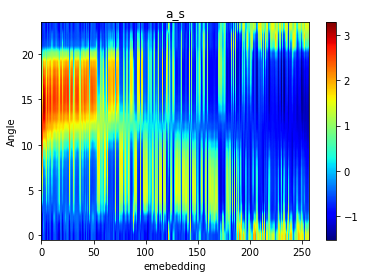

In [126]:
im = plt.imshow(val3, cmap=cm.jet, aspect='auto',origin='lower')
plt.colorbar(im)
plt.title("a_s")
plt.xlabel('emebedding')
plt.ylabel('Angle')

Text(0, 0.5, 'Angle')

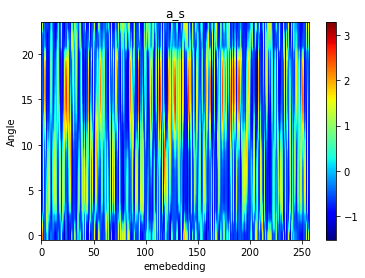

In [93]:
im = plt.imshow(val, cmap=cm.jet, aspect='auto',origin='lower')
plt.colorbar(im)
plt.title("a_s")
plt.xlabel('emebedding')
plt.ylabel('Angle')

Text(0, 0.5, 'Angle')

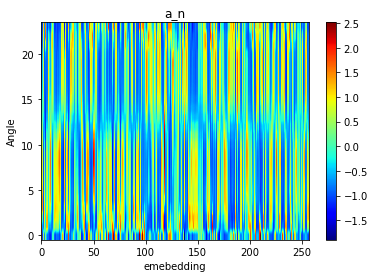

In [113]:
im = plt.imshow(val2, cmap=cm.jet, aspect='auto',origin='lower')
plt.colorbar(im)
plt.title("a_n")
plt.xlabel('emebedding')
plt.ylabel('Angle')

Text(0, 0.5, 'Angle')

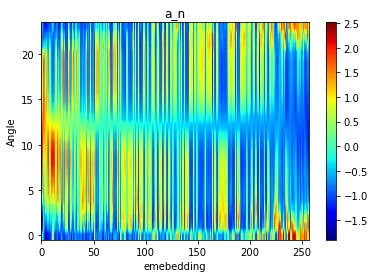

In [117]:
idx = val2.mean(axis=0).argsort()[::-1]
val4 = val2[:,idx]
im = plt.imshow(val4, cmap=cm.jet, aspect='auto',origin='lower')
plt.colorbar(im)
plt.title("a_n")
plt.xlabel('emebedding')
plt.ylabel('Angle')